# Clasificación de Cobertura Forestal con MLP en PyTorch

## Introducción

En este proyecto construiremos, entrenaremos y evaluaremos un Perceptron Multicapa (MLP) para clasificar tipos de cobertura forestal utilizando el dataset CoverType. Este dataset contiene informacion cartográfica de áreas silvestres en el Roosevelt National Forest de Colorado, Estados Unidos.

El objetivo principal es alcanzar al menos un 93% de accuracy en el conjunto de prueba, lo cual requerirá una exploración cuidadosa de los datos, preprocesamiento adecuado y búsqueda de hiperparámetros.

## Workflow

1. Configuración del entorno y verificación de GPU
2. Carga y exploración del dataset
3. Preprocesamiento de datos
4. Creación del Dataset y DataLoaders de PyTorch
5. Construcción de la arquitectura MLP
6. Entrenamiento del modelo
7. Evaluación y análisis de resultados
8. Búsqueda de hiperparámetros con Optuna
9. Conclusiones y oportunidades de mejora

In [1]:
# Configuración e importación de librerías

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Verificación del entorno
print('Versiones del entorno:')
print(f'PyTorch: {torch.__version__}')
print(f'NumPy: {np.__version__}')
print(f'Pandas: {pd.__version__}')
print()
print('Configuración de GPU:')
print(f'CUDA disponible: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'Dispositivo: {torch.cuda.get_device_name(0)}')
    print(f'Memoria total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')
    
# Definir dispositivo para entrenamiento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'\nDispositivo de entrenamiento: {device}')

Versiones del entorno:
PyTorch: 2.9.0+cu130
NumPy: 2.3.5
Pandas: 2.3.3

Configuración de GPU:
CUDA disponible: True
Dispositivo: NVIDIA GeForce RTX 3050 6GB Laptop GPU
Memoria total: 6.44 GB

Dispositivo de entrenamiento: cuda


## 1. Carga y Exploración del Dataset

El dataset CoverType proviene del UCI Machine Learning Repository y contiene 581,012 observaciones con 54 características. Cada observación representa una celda de 30x30 metros del bosque, y la tarea es predecir cuál de los 7 tipos de cobertura forestal corresponde a esa área.

Las características incluyen:
- Elevación, pendiente y aspecto del terreno
- Distancias horizontales y verticales a puntos de referencia (hidrología, carreteras, puntos de fuego)
- Sombra a diferentes horas del día
- Variables binarias para tipo de área silvestre (4 categorías)
- Variables binarias para tipo de suelo (40 categorías)

In [2]:
# Carga del dataset
covtype = fetch_covtype(as_frame=True)

# Separar características y etiquetas
X = covtype.data
y = covtype.target

print(f'Dataset cargado exitosamente.')
print(f'\nDimensiones:')
print(f'Características (X): {X.shape}')
print(f'Etiquetas (y): {y.shape}')
print(f'\nNúmero de clases: {y.nunique()}')
print(f'Clases: {sorted(y.unique())}')

Dataset cargado exitosamente.

Dimensiones:
Características (X): (581012, 54)
Etiquetas (y): (581012,)

Número de clases: 7
Clases: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7)]


### 1.1 Análisis Exploratorio de las Características

Examinaremos la estructura de los datos, estadísticas descriptivas y la distribución de las variables numéricas continuas. Las primeras 10 columnas son características numéricas continuas, mientras que las restantes 44 son variables binarias (one-hot encoding de área silvestre y tipo de suelo).

In [3]:
# Información general del dataset
print('Información del DataFrame:')
print(f'Memoria utilizada: {X.memory_usage(deep=True).sum() / 1e6:.2f} MB')
print(f'Valores nulos: {X.isnull().sum().sum()}')
print(f'Tipos de datos únicos: {X.dtypes.nunique()}')

# Nombres de las características
feature_names = X.columns.tolist()
print(f'\nCaracterísticas continuas (primeras 10):')
for i, name in enumerate(feature_names[:10]):
    print(f'{i+1}. {name}')

print(f'\nCaracterísticas binarias:')
print(f'Áreas silvestres: {feature_names[10:14]}')
print(f'Tipos de suelo: {len(feature_names[14:])} variables (Soil_Type1 a Soil_Type40)')

Información del DataFrame:
Memoria utilizada: 251.00 MB
Valores nulos: 0
Tipos de datos únicos: 1

Características continuas (primeras 10):
1. Elevation
2. Aspect
3. Slope
4. Horizontal_Distance_To_Hydrology
5. Vertical_Distance_To_Hydrology
6. Horizontal_Distance_To_Roadways
7. Hillshade_9am
8. Hillshade_Noon
9. Hillshade_3pm
10. Horizontal_Distance_To_Fire_Points

Características binarias:
Áreas silvestres: ['Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3']
Tipos de suelo: 40 variables (Soil_Type1 a Soil_Type40)


In [4]:
# Estadísticas descriptivas de las características continuas
continuous_features = feature_names[:10]
print('Estadísticas descriptivas de características continuas:\n')
X[continuous_features].describe().round(2)

Estadísticas descriptivas de características continuas:



,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
count,581012.00,581012.00,581012.00,581012.00,581012.00,581012.00,581012.00,581012.00,581012.00,581012.00
mean,2959.37,155.66,14.10,269.43,46.42,2350.15,212.15,223.32,142.53,1980.29
std,279.98,111.91,7.49,212.55,58.30,1559.25,26.77,19.77,38.27,1324.20
min,1859.00,0.00,0.00,0.00,-173.00,0.00,0.00,0.00,0.00,0.00
25%,2809.00,58.00,9.00,108.00,7.00,1106.00,198.00,213.00,119.00,1024.00
50%,2996.00,127.00,13.00,218.00,30.00,1997.00,218.00,226.00,143.00,1710.00
75%,3163.00,260.00,18.00,384.00,69.00,3328.00,231.00,237.00,168.00,2550.00
max,3858.00,360.00,66.00,1397.00,601.00,7117.00,254.00,254.00,254.00,7173.00


### 1.2 Distribución de Clases

Es fundamental analizar el balance de clases antes de entrenar el modelo. Un desbalance significativo puede afectar el rendimiento del clasificador y requerir técnicas especiales de manejo.

In [5]:
# Distribución de clases
class_counts = y.value_counts().sort_index()
class_percentages = (class_counts / len(y) * 100).round(2)

print('Distribución de clases:\n')
for cls, count in class_counts.items():
    pct = class_percentages[cls]
    print(f'Clase {cls}: {count:,} muestras ({pct}%)')

# Nombres descriptivos de las clases de cobertura forestal
cover_types = {
    1: 'Spruce/Fir',
    2: 'Lodgepole Pine', 
    3: 'Ponderosa Pine',
    4: 'Cottonwood/Willow',
    5: 'Aspen',
    6: 'Douglas-fir',
    7: 'Krummholz'
}

print('\nTipos de cobertura forestal:')
for cls, name in cover_types.items():
    print(f'Clase {cls}: {name}')

Distribución de clases:

Clase 1: 211,840 muestras (36.46%)
Clase 2: 283,301 muestras (48.76%)
Clase 3: 35,754 muestras (6.15%)
Clase 4: 2,747 muestras (0.47%)
Clase 5: 9,493 muestras (1.63%)
Clase 6: 17,367 muestras (2.99%)
Clase 7: 20,510 muestras (3.53%)

Tipos de cobertura forestal:
Clase 1: Spruce/Fir
Clase 2: Lodgepole Pine
Clase 3: Ponderosa Pine
Clase 4: Cottonwood/Willow
Clase 5: Aspen
Clase 6: Douglas-fir
Clase 7: Krummholz


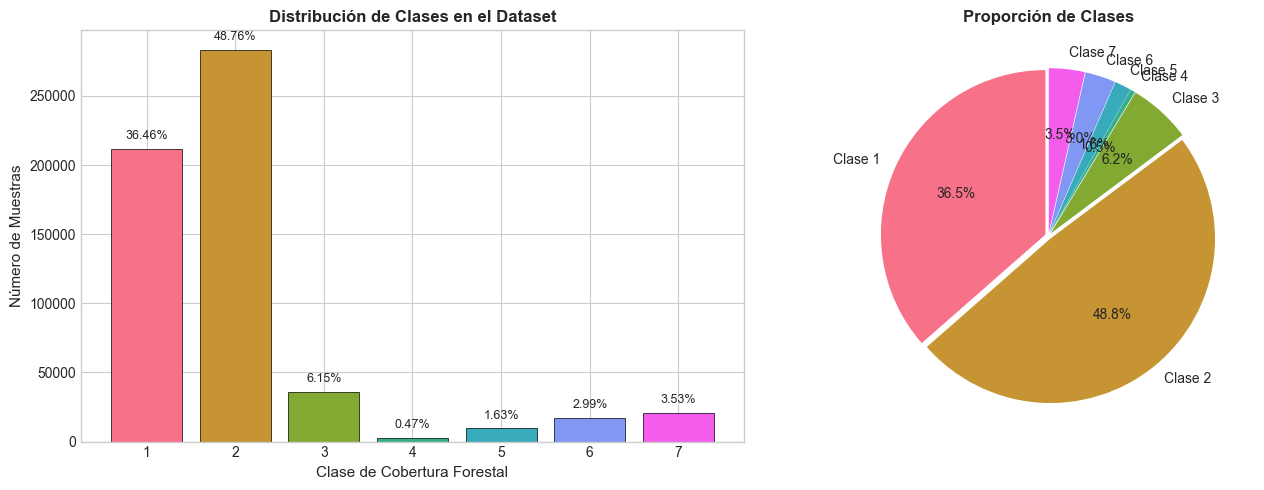


Ratio de desbalance (clase mayoritaria / clase minoritaria): 103.1x


In [6]:
# Visualización de la distribución de clases
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
colors = sns.color_palette('husl', n_colors=7)
bars = axes[0].bar(class_counts.index, class_counts.values, color=colors, edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Clase de Cobertura Forestal', fontsize=11)
axes[0].set_ylabel('Número de Muestras', fontsize=11)
axes[0].set_title('Distribución de Clases en el Dataset', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(1, 8))

# Añadir etiquetas de porcentaje
for bar, pct in zip(bars, class_percentages.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000, 
                 f'{pct}%', ha='center', va='bottom', fontsize=9)

# Gráfico de pastel
axes[1].pie(class_counts.values, labels=[f'Clase {i}' for i in class_counts.index],
            autopct='%1.1f%%', colors=colors, explode=[0.02]*7, startangle=90)
axes[1].set_title('Proporción de Clases', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Análisis del desbalance
ratio = class_counts.max() / class_counts.min()
print(f'\nRatio de desbalance (clase mayoritaria / clase minoritaria): {ratio:.1f}x')

### 1.3 Distribución de Características Continuas

Analizaremos la distribución de las 10 características numéricas continuas para entender su comportamiento y detectar posibles outliers o transformaciones necesarias.

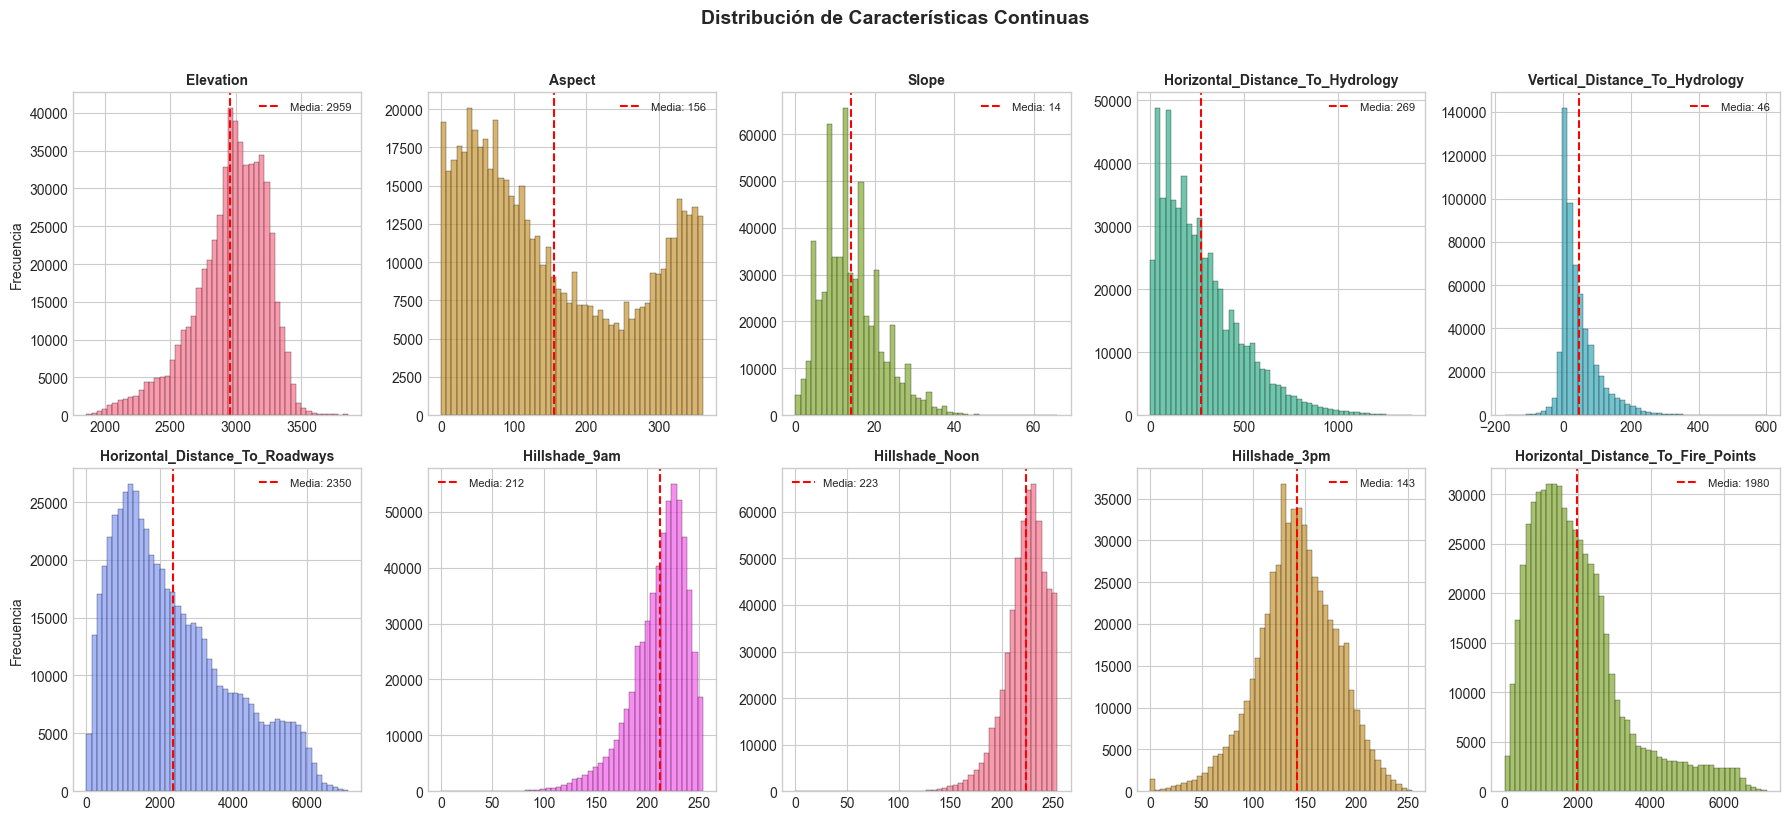

In [7]:
# Distribución de características continuas
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(continuous_features):
    axes[i].hist(X[col], bins=50, color=colors[i % 7], edgecolor='black', linewidth=0.3, alpha=0.7)
    axes[i].set_title(col, fontsize=10, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frecuencia' if i % 5 == 0 else '')
    
    # Añadir línea de media
    mean_val = X[col].mean()
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Media: {mean_val:.0f}')
    axes[i].legend(fontsize=8)

plt.suptitle('Distribución de Características Continuas', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 1.4 Correlación entre Características

La matriz de correlación nos ayudará a identificar relaciones lineales entre variables y posible multicolinealidad que podría afectar el entrenamiento.

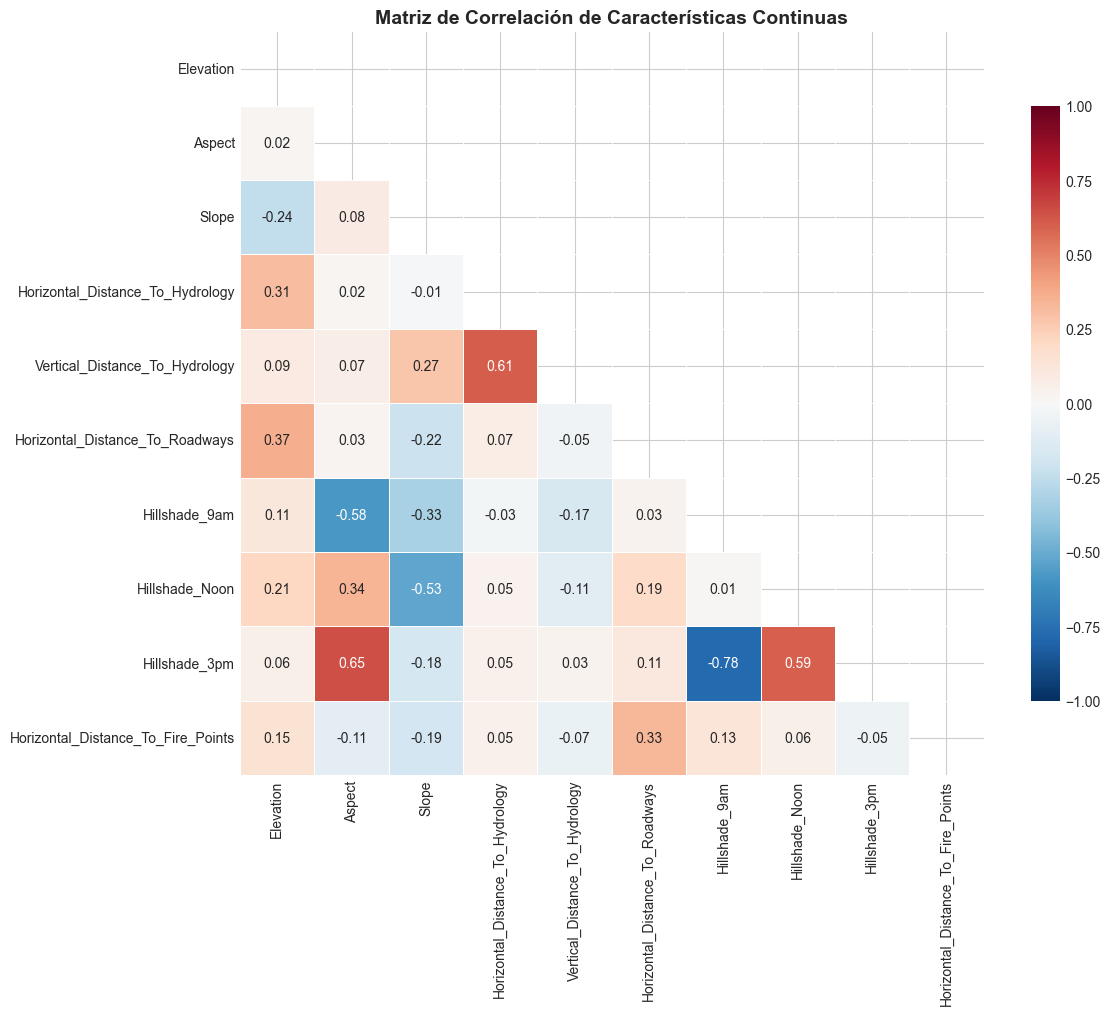

Correlaciones más fuertes (|r| > 0.5):
Aspect <-> Hillshade_9am: -0.579
Aspect <-> Hillshade_3pm: 0.647
Slope <-> Hillshade_Noon: -0.527
Horizontal_Distance_To_Hydrology <-> Vertical_Distance_To_Hydrology: 0.606
Hillshade_9am <-> Hillshade_3pm: -0.780
Hillshade_Noon <-> Hillshade_3pm: 0.594


In [8]:
# Matriz de correlación de características continuas
correlation_matrix = X[continuous_features].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=0.5, cbar_kws={'shrink': 0.8},
            vmin=-1, vmax=1)
plt.title('Matriz de Correlación de Características Continuas', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Identificar correlaciones fuertes
print('Correlaciones más fuertes (|r| > 0.5):')
for i in range(len(continuous_features)):
    for j in range(i+1, len(continuous_features)):
        corr = correlation_matrix.iloc[i, j]
        if abs(corr) > 0.5:
            print(f'{continuous_features[i]} <-> {continuous_features[j]}: {corr:.3f}')

## 2. Preprocesamiento de Datos

Antes de entrenar el modelo, debemos preparar los datos adecuadamente:

1. Convertir las etiquetas al rango [0, 6] en lugar de [1, 7] para compatibilidad con PyTorch
2. Dividir en conjuntos de entrenamiento, validación y prueba
3. Escalar las características continuas usando StandardScaler
4. Mantener las características binarias sin escalar (ya están en rango 0-1)

La división será 70% entrenamiento, 15% validación y 15% prueba.

In [9]:
# Convertir etiquetas al rango [0, 6]
y_adjusted = y - 1

print('Ajuste de etiquetas:')
print(f'Rango original: [{y.min()}, {y.max()}]')
print(f'Rango ajustado: [{y_adjusted.min()}, {y_adjusted.max()}]')

# División de datos: 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_adjusted, test_size=0.15, random_state=42, stratify=y_adjusted
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # 0.176 de 0.85 ≈ 0.15 del total
)

print(f'\nDivisión de datos:')
print(f'Entrenamiento: {X_train.shape[0]:,} muestras ({X_train.shape[0]/len(X)*100:.1f}%)')
print(f'Validación: {X_val.shape[0]:,} muestras ({X_val.shape[0]/len(X)*100:.1f}%)')
print(f'Prueba: {X_test.shape[0]:,} muestras ({X_test.shape[0]/len(X)*100:.1f}%)')

Ajuste de etiquetas:
Rango original: [1, 7]
Rango ajustado: [0, 6]

División de datos:
Entrenamiento: 406,940 muestras (70.0%)
Validación: 86,920 muestras (15.0%)
Prueba: 87,152 muestras (15.0%)


In [10]:
# Separar características continuas y binarias
continuous_cols = feature_names[:10]
binary_cols = feature_names[10:]

print(f'Características continuas: {len(continuous_cols)}')
print(f'Características binarias: {len(binary_cols)}')

# Escalar solo las características continuas
scaler = StandardScaler()

# Ajustar el scaler solo con datos de entrenamiento (evitar data leakage)
X_train_continuous = scaler.fit_transform(X_train[continuous_cols])
X_val_continuous = scaler.transform(X_val[continuous_cols])
X_test_continuous = scaler.transform(X_test[continuous_cols])

# Mantener las características binarias sin cambios
X_train_binary = X_train[binary_cols].values
X_val_binary = X_val[binary_cols].values
X_test_binary = X_test[binary_cols].values

# Concatenar características continuas escaladas con binarias
X_train_processed = np.hstack([X_train_continuous, X_train_binary])
X_val_processed = np.hstack([X_val_continuous, X_val_binary])
X_test_processed = np.hstack([X_test_continuous, X_test_binary])

print(f'\nForma de datos procesados:')
print(f'X_train: {X_train_processed.shape}')
print(f'X_val: {X_val_processed.shape}')
print(f'X_test: {X_test_processed.shape}')

# Verificar el escalado
print(f'\nVerificación del escalado (características continuas en entrenamiento):')
print(f'Media (debe ser ~0): {X_train_continuous.mean(axis=0).mean():.6f}')
print(f'Desviación estándar (debe ser ~1): {X_train_continuous.std(axis=0).mean():.6f}')

Características continuas: 10
Características binarias: 44

Forma de datos procesados:
X_train: (406940, 54)
X_val: (86920, 54)
X_test: (87152, 54)

Verificación del escalado (características continuas en entrenamiento):
Media (debe ser ~0): 0.000000
Desviación estándar (debe ser ~1): 1.000000


## 3. Creación del Dataset y DataLoaders de PyTorch

Crearemos una clase Dataset personalizada que hereda de torch.utils.data.Dataset. Esta clase permitirá que PyTorch maneje eficientemente los datos durante el entrenamiento, incluyendo el batching y shuffling automático.

In [11]:
# Dataset personalizado para CoverType
class CoverTypeDataset(Dataset):
    """
    Dataset personalizado para el problema de clasificación de cobertura forestal.
    Parámetros:
        X: numpy array con las características
        y: numpy array con las etiquetas
    """
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values if hasattr(y, 'values') else y, dtype=torch.long)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Crear los datasets
train_dataset = CoverTypeDataset(X_train_processed, y_train)
val_dataset = CoverTypeDataset(X_val_processed, y_val)
test_dataset = CoverTypeDataset(X_test_processed, y_test)

print('Datasets creados:')
print(f'Train: {len(train_dataset)} muestras')
print(f'Validation: {len(val_dataset)} muestras')
print(f'Test: {len(test_dataset)} muestras')

# Verificar una muestra
sample_X, sample_y = train_dataset[0]
print(f'\nVerificación de una muestra:')
print(f'Forma de X: {sample_X.shape}')
print(f'Tipo de X: {sample_X.dtype}')
print(f'Etiqueta y: {sample_y.item()}')
print(f'Tipo de y: {sample_y.dtype}')

Datasets creados:
Train: 406940 muestras
Validation: 86920 muestras
Test: 87152 muestras

Verificación de una muestra:
Forma de X: torch.Size([54])
Tipo de X: torch.float32
Etiqueta y: 1
Tipo de y: torch.int64


In [12]:
# Crear DataLoaders
BATCH_SIZE = 256

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print('DataLoaders creados:')
print(f'Batch size: {BATCH_SIZE}')
print(f'Batches en train: {len(train_loader)}')
print(f'Batches en validation: {len(val_loader)}')
print(f'Batches en test: {len(test_loader)}')

# Verificar un batch
batch_X, batch_y = next(iter(train_loader))
print(f'\nVerificación de un batch:')
print(f'Forma de X: {batch_X.shape}')
print(f'Forma de y: {batch_y.shape}')
print(f'Dispositivo: {batch_X.device}')

DataLoaders creados:
Batch size: 256
Batches en train: 1590
Batches en validation: 340
Batches en test: 341

Verificación de un batch:
Forma de X: torch.Size([256, 54])
Forma de y: torch.Size([256])
Dispositivo: cpu


## 4. Construcción de la Arquitectura MLP

Diseñaremos un Perceptron Multicapa con las siguientes características:

- Capas ocultas con activación ReLU
- Batch Normalization para estabilizar el entrenamiento
- Dropout para regularización y prevenir overfitting
- Capa de salida con 7 neuronas (una por clase)

La arquitectura inicial será relativamente profunda para capturar patrones complejos en los datos. Posteriormente optimizaremos los hiperparámetros con Optuna.

In [13]:
class MLP(nn.Module):
    """
    Perceptron Multicapa para clasificación de cobertura forestal.
    Parámetros:
        input_size: número de características de entrada
        hidden_sizes: lista con el número de neuronas en cada capa oculta
        num_classes: número de clases de salida
        dropout_rate: probabilidad de dropout
    """
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_rate=0.3):
        super(MLP, self).__init__()
        
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        
        # Construir las capas dinámicamente
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        
        # Capa de salida (sin activación, se aplica en la loss function)
        layers.append(nn.Linear(prev_size, num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)
    
    def count_parameters(self):
        """Cuenta el número total de parámetros entrenables."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# Definir la arquitectura inicial
INPUT_SIZE = 54
NUM_CLASSES = 7
HIDDEN_SIZES = [256, 128, 64]
DROPOUT_RATE = 0.3

# Crear el modelo
model = MLP(
    input_size=INPUT_SIZE,
    hidden_sizes=HIDDEN_SIZES,
    num_classes=NUM_CLASSES,
    dropout_rate=DROPOUT_RATE
)

# Mover el modelo a GPU
model = model.to(device)

print('Arquitectura del modelo:')
print(model)
print(f'\nParámetros entrenables: {model.count_parameters():,}')
print(f'Dispositivo: {next(model.parameters()).device}')

Arquitectura del modelo:
MLP(
  (network): Sequential(
    (0): Linear(in_features=54, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=7, bias=True)
  )
)

Parámetros entrenables: 56,583
Dispositivo: cuda:0


## 5. Configuración del Entrenamiento

Para manejar el desbalance de clases utilizaremos pesos inversamente proporcionales a la frecuencia de cada clase. Esto penalizará más los errores en las clases minoritarias.

Componentes del entrenamiento:
- Función de pérdida: CrossEntropyLoss con pesos de clase
- Optimizador: Adam con learning rate inicial
- Scheduler: ReduceLROnPlateau para ajustar el learning rate cuando el modelo deje de mejorar

In [14]:
# Calcular pesos de clase para manejar el desbalance
class_counts = np.bincount(y_train.values)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)  # Normalizar
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

print('Pesos de clase para manejar el desbalance:')
for i, (count, weight) in enumerate(zip(class_counts, class_weights)):
    print(f'Clase {i}: {count:,} muestras -> peso {weight:.4f}')

# Configuración del entrenamiento
LEARNING_RATE = 0.001
EPOCHS = 50

# Función de pérdida con pesos de clase
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizador Adam
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Scheduler para reducir el learning rate cuando la validación no mejore
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print(f'\nConfiguración:')
print(f'Learning rate inicial: {LEARNING_RATE}')
print(f'Épocas máximas: {EPOCHS}')
print(f'Optimizador: Adam')
print(f'Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)')

Pesos de clase para manejar el desbalance:
Clase 0: 148,372 muestras -> peso 0.0540
Clase 1: 198,424 muestras -> peso 0.0404
Clase 2: 25,042 muestras -> peso 0.3199
Clase 3: 1,924 muestras -> peso 4.1643
Clase 4: 6,649 muestras -> peso 1.2050
Clase 5: 12,164 muestras -> peso 0.6587
Clase 6: 14,365 muestras -> peso 0.5577

Configuración:
Learning rate inicial: 0.001
Épocas máximas: 50
Optimizador: Adam
Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)


## 6. Funciones de Entrenamiento y Evaluación

Implementaremos funciones separadas para entrenar una época y evaluar el modelo. Esto permite un código más limpio y reutilizable. También implementaremos early stopping para detener el entrenamiento si el modelo deja de mejorar.

In [15]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Entrena el modelo por una época.
    Retorna:
        train_loss: pérdida promedio en entrenamiento
        train_acc: accuracy en entrenamiento
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Estadísticas
        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    train_loss = running_loss / total
    train_acc = correct / total
    
    return train_loss, train_acc


def evaluate(model, data_loader, criterion, device):
    """
    Evalúa el modelo en un conjunto de datos.
    Retorna:
        eval_loss: pérdida promedio
        eval_acc: accuracy
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            running_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    
    eval_loss = running_loss / total
    eval_acc = correct / total
    
    return eval_loss, eval_acc

In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                device, epochs, patience=10):
    """
    Entrena el modelo completo con early stopping.
    Parámetros:
        patience: épocas sin mejora antes de detener el entrenamiento
    Retorna:
        history: diccionario con el historial de entrenamiento
    """
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'lr': []
    }
    
    best_val_loss = float('inf')
    best_model_state = None
    epochs_without_improvement = 0
    
    print('Iniciando entrenamiento\n')
    print(f'{"Época":<8} {"Train Loss":<12} {"Train Acc":<12} {"Val Loss":<12} {"Val Acc":<12} {"LR":<12}')
    
    for epoch in range(epochs):
        # Entrenar una época
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Evaluar en validación
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        # Obtener learning rate actual
        current_lr = optimizer.param_groups[0]['lr']
        
        # Guardar historial
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        
        # Imprimir progreso
        print(f'{epoch+1:<8} {train_loss:<12.4f} {train_acc:<12.4f} {val_loss:<12.4f} {val_acc:<12.4f} {current_lr:<12.6f}')
        
        # Actualizar scheduler
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= patience:
            print(f'\nEarly stopping en época {epoch+1}. Sin mejora por {patience} épocas.')
            break
    
    # Restaurar el mejor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f'\nMejor modelo restaurado (val_loss: {best_val_loss:.4f})')
    
    return history

print('Función de entrenamiento completo definida correctamente.')

Función de entrenamiento completo definida correctamente.


## 7. Entrenamiento del Modelo

Ejecutaremos el entrenamiento con los hiperparámetros definidos. El modelo entrenará por un máximo de 50 épocas, pero se detendrá antes si no hay mejora en la pérdida de validación por 10 épocas consecutivas (early stopping).

In [17]:
# Entrenar el modelo
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=EPOCHS,
    patience=10
)

Iniciando entrenamiento

Época    Train Loss   Train Acc    Val Loss     Val Acc      LR          
1        0.7743       0.5730       0.5684       0.6408       0.001000    
2        0.6283       0.6252       0.5720       0.6663       0.001000    
3        0.5863       0.6450       0.5008       0.6704       0.001000    
4        0.5620       0.6570       0.4697       0.6893       0.001000    
5        0.5429       0.6673       0.4607       0.6946       0.001000    
6        0.5216       0.6765       0.4394       0.7098       0.001000    
7        0.5110       0.6810       0.4217       0.7116       0.001000    
8        0.4958       0.6883       0.4005       0.7255       0.001000    
9        0.4864       0.6925       0.3981       0.7298       0.001000    
10       0.4804       0.6970       0.3968       0.7310       0.001000    
11       0.4715       0.7007       0.3840       0.7241       0.001000    
12       0.4630       0.7041       0.3717       0.7427       0.001000    
13       0.45

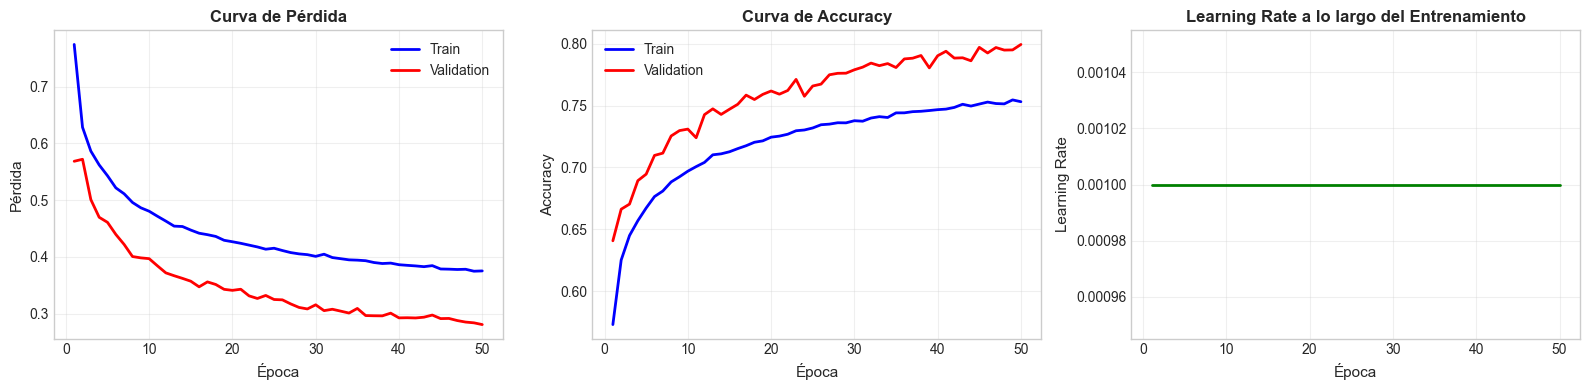


Resumen del entrenamiento:
Mejor accuracy en validación: 79.95%
Mejor pérdida en validación: 0.2806
Épocas totales: 50


In [18]:
# Visualizar el historial de entrenamiento
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

epochs_range = range(1, len(history['train_loss']) + 1)

# Gráfico de pérdida
axes[0].plot(epochs_range, history['train_loss'], 'b-', label='Train', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], 'r-', label='Validation', linewidth=2)
axes[0].set_xlabel('Época', fontsize=11)
axes[0].set_ylabel('Pérdida', fontsize=11)
axes[0].set_title('Curva de Pérdida', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfico de accuracy
axes[1].plot(epochs_range, history['train_acc'], 'b-', label='Train', linewidth=2)
axes[1].plot(epochs_range, history['val_acc'], 'r-', label='Validation', linewidth=2)
axes[1].set_xlabel('Época', fontsize=11)
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].set_title('Curva de Accuracy', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Gráfico de learning rate
axes[2].plot(epochs_range, history['lr'], 'g-', linewidth=2)
axes[2].set_xlabel('Época', fontsize=11)
axes[2].set_ylabel('Learning Rate', fontsize=11)
axes[2].set_title('Learning Rate a lo largo del Entrenamiento', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'\nResumen del entrenamiento:')
print(f'Mejor accuracy en validación: {max(history["val_acc"])*100:.2f}%')
print(f'Mejor pérdida en validación: {min(history["val_loss"]):.4f}')
print(f'Épocas totales: {len(history["train_loss"])}')

## 8. Evaluación en el Conjunto de Prueba

Evaluaremos el modelo en el conjunto de prueba que no se ha utilizado durante el entrenamiento. Analizaremos el accuracy general, el reporte de clasificación por clase y la matriz de confusión.

In [19]:
# Evaluación final en el conjunto de prueba
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print('Evaluación en el conjunto de prueba:')
print(f'Pérdida: {test_loss:.4f}')
print(f'Accuracy: {test_acc*100:.2f}%')
print(f'\nObjetivo: 93.00%')
print(f'Diferencia: {(93.0 - test_acc*100):.2f}%')

Evaluación en el conjunto de prueba:
Pérdida: 0.2804
Accuracy: 80.05%

Objetivo: 93.00%
Diferencia: 12.95%


In [20]:
# Obtener predicciones detalladas en el conjunto de prueba
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Reporte de clasificación
print('Reporte de Clasificación:\n')
target_names = [f'Clase {i} ({cover_types[i+1]})' for i in range(7)]
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))

Reporte de Clasificación:

                             precision    recall  f1-score   support

       Clase 0 (Spruce/Fir)     0.8287    0.8073    0.8179     31776
   Clase 1 (Lodgepole Pine)     0.8782    0.7637    0.8170     42495
   Clase 2 (Ponderosa Pine)     0.8206    0.8255    0.8230      5363
Clase 3 (Cottonwood/Willow)     0.5956    0.9830    0.7418       412
            Clase 4 (Aspen)     0.3116    0.9761    0.4724      1424
      Clase 5 (Douglas-fir)     0.5668    0.9213    0.7019      2605
        Clase 6 (Krummholz)     0.6789    0.9873    0.8046      3077

                   accuracy                         0.8005     87152
                  macro avg     0.6686    0.8949    0.7398     87152
               weighted avg     0.8297    0.8005    0.8078     87152



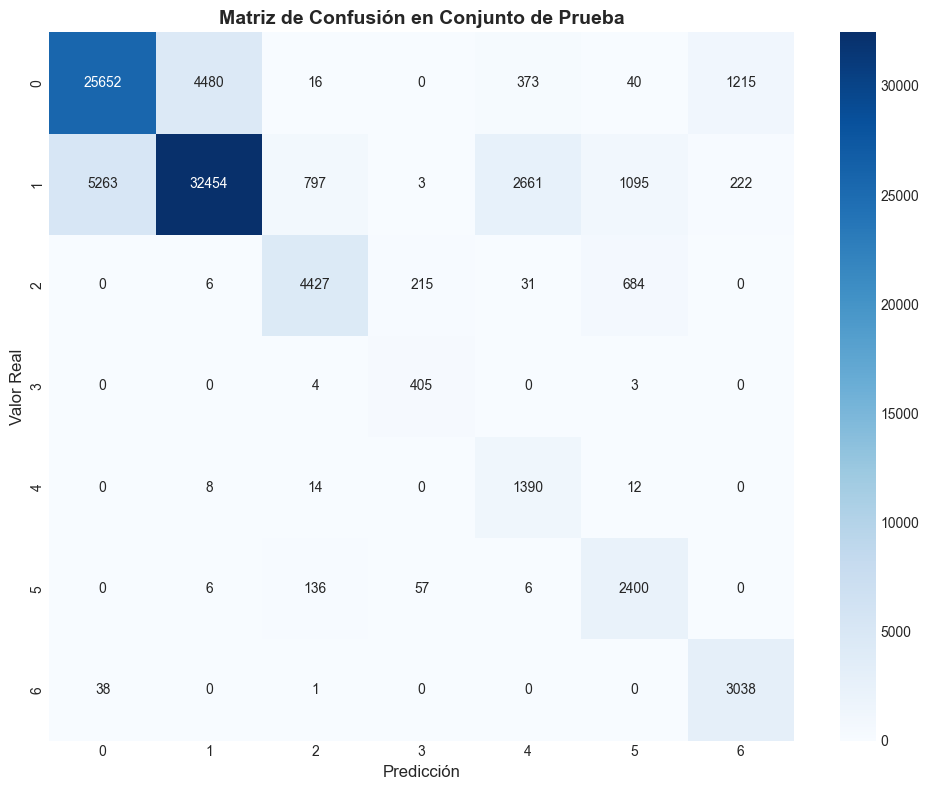


Análisis de accuracy por clase:
Clase 0 (Spruce/Fir): 80.73%
Clase 1 (Lodgepole Pine): 76.37%
Clase 2 (Ponderosa Pine): 82.55%
Clase 3 (Cottonwood/Willow): 98.30%
Clase 4 (Aspen): 97.61%
Clase 5 (Douglas-fir): 92.13%
Clase 6 (Krummholz): 98.73%


In [21]:
# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'{i}' for i in range(7)],
            yticklabels=[f'{i}' for i in range(7)])
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.title('Matriz de Confusión en Conjunto de Prueba', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Análisis de errores por clase
print('\nAnálisis de accuracy por clase:')
for i in range(7):
    class_mask = all_labels == i
    class_acc = (all_preds[class_mask] == all_labels[class_mask]).mean()
    print(f'Clase {i} ({cover_types[i+1]}): {class_acc*100:.2f}%')

## 9. Optimización de Hiperparámetros con Optuna

Para alcanzar el objetivo del 93% de accuracy, utilizaremos Optuna para buscar automáticamente la mejor combinación de hiperparámetros. Exploraremos:

- Número de capas ocultas (2-5)
- Número de neuronas por capa (128-512)
- Tasa de dropout (0.1-0.5)
- Learning rate (1e-4 a 1e-2)
- Batch size (128, 256, 512)

Optuna utiliza un algoritmo de optimización bayesiana (TPE) que es más eficiente que una búsqueda aleatoria o en cuadrícula.

In [22]:
import optuna
from optuna.trial import TrialState

def create_model(trial):
    """Crea un modelo MLP con hiperparámetros sugeridos por Optuna."""
    
    # Número de capas ocultas
    n_layers = trial.suggest_int('n_layers', 2, 5)
    
    # Neuronas por capa (decreciente)
    hidden_sizes = []
    first_layer_size = trial.suggest_int('first_layer_size', 256, 512, step=64)
    
    for i in range(n_layers):
        if i == 0:
            hidden_sizes.append(first_layer_size)
        else:
            # Cada capa tiene entre 50% y 100% del tamaño de la anterior
            prev_size = hidden_sizes[-1]
            layer_size = trial.suggest_int(f'layer_{i}_size', max(64, prev_size // 2), prev_size, step=32)
            hidden_sizes.append(layer_size)
    
    # Dropout rate
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    model = MLP(
        input_size=INPUT_SIZE,
        hidden_sizes=hidden_sizes,
        num_classes=NUM_CLASSES,
        dropout_rate=dropout_rate
    )
    
    return model.to(device)


def objective(trial):
    """Función objetivo para Optuna."""
    
    # Crear modelo
    model = create_model(trial)
    
    # Hiperparámetros de entrenamiento
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
    
    # Crear DataLoaders con el batch size sugerido
    train_loader_opt = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                   num_workers=0, pin_memory=True)
    val_loader_opt = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                                 num_workers=0, pin_memory=True)
    
    # Configurar optimizador
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Entrenar por un número reducido de épocas para evaluación rápida
    n_epochs = 20
    best_val_acc = 0
    
    for epoch in range(n_epochs):
        # Entrenar
        model.train()
        for X_batch, y_batch in train_loader_opt:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        
        # Evaluar
        val_loss, val_acc = evaluate(model, val_loader_opt, criterion, device)
        
        # Reportar al pruner
        trial.report(val_acc, epoch)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
        
        best_val_acc = max(best_val_acc, val_acc)
    
    return best_val_acc


print('Funciones de Optuna definidas correctamente.')
print(f'Se explorarán combinaciones de:')
print(f'- Capas ocultas: 2-5')
print(f'- Neuronas primera capa: 256-512')
print(f'- Dropout: 0.1-0.5')
print(f'- Learning rate: 1e-4 a 1e-2')
print(f'- Batch size: 128, 256, 512')

Funciones de Optuna definidas correctamente.
Se explorarán combinaciones de:
- Capas ocultas: 2-5
- Neuronas primera capa: 256-512
- Dropout: 0.1-0.5
- Learning rate: 1e-4 a 1e-2
- Batch size: 128, 256, 512


In [23]:
# Crear estudio de Optuna y ejecutar optimización
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
)

# Ejecutar 30 trials
study.optimize(objective, n_trials=30, show_progress_bar=True)

print(f'\nBúsqueda completada.')
print(f'Mejor accuracy en validación: {study.best_value*100:.2f}%')

[I 2025-12-27 01:59:20,184] A new study created in memory with name: no-name-7d317851-8734-4286-b80f-d8ea20cde1e8


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-27 02:01:56,761] Trial 0 finished with value: 0.847583985273815 and parameters: {'n_layers': 3, 'first_layer_size': 512, 'layer_1_size': 448, 'layer_2_size': 352, 'dropout_rate': 0.1624074561769746, 'lr': 0.00020511104188433984, 'batch_size': 256}. Best is trial 0 with value: 0.847583985273815.
[I 2025-12-27 02:04:59,582] Trial 1 finished with value: 0.8158421537045559 and parameters: {'n_layers': 4, 'first_layer_size': 256, 'layer_1_size': 256, 'layer_2_size': 256, 'layer_3_size': 160, 'dropout_rate': 0.17272998688284025, 'lr': 0.00023270677083837802, 'batch_size': 256}. Best is trial 0 with value: 0.847583985273815.
[I 2025-12-27 02:09:24,215] Trial 2 finished with value: 0.8222158306488725 and parameters: {'n_layers': 3, 'first_layer_size': 448, 'layer_1_size': 256, 'layer_2_size': 160, 'dropout_rate': 0.2465447373174767, 'lr': 0.000816845589476017, 'batch_size': 128}. Best is trial 0 with value: 0.847583985273815.
[I 2025-12-27 02:14:58,857] Trial 3 finished with value: 

In [24]:
# Mostrar mejores hiperparámetros
print('Mejores hiperparámetros encontrados:\n')
for key, value in study.best_params.items():
    print(f'{key}: {value}')

# Mostrar top 5 trials
print('\nTop 5 trials:')
trials_df = study.trials_dataframe()
trials_df = trials_df[trials_df['state'] == 'COMPLETE'].sort_values('value', ascending=False)
print(trials_df[['number', 'value', 'params_n_layers', 'params_first_layer_size', 
                  'params_dropout_rate', 'params_lr', 'params_batch_size']].head().to_string(index=False))

Mejores hiperparámetros encontrados:

n_layers: 4
first_layer_size: 512
layer_1_size: 480
layer_2_size: 400
layer_3_size: 360
dropout_rate: 0.12743121637528887
lr: 0.0003871312045590575
batch_size: 256

Top 5 trials:
 number    value  params_n_layers  params_first_layer_size  params_dropout_rate  params_lr  params_batch_size
     24 0.877439                4                      512             0.127431   0.000387                256
     12 0.871790                5                      448             0.106023   0.000303                256
     11 0.870249                5                      448             0.106260   0.000341                256
     13 0.868488                5                      448             0.114368   0.000441                256
     21 0.867821                5                      448             0.117755   0.000402                256


## 10. Entrenamiento del Modelo Optimizado

Entrenaremos un nuevo modelo con los mejores hiperparámetros encontrados por Optuna. Esta vez entrenaremos por más épocas para maximizar el rendimiento.

In [25]:
# Crear modelo con los mejores hiperparámetros
best_params = study.best_params

# Reconstruir la arquitectura
best_hidden_sizes = [best_params['first_layer_size']]
for i in range(1, best_params['n_layers']):
    best_hidden_sizes.append(best_params[f'layer_{i}_size'])

print('Arquitectura optimizada:')
print(f'Capas ocultas: {best_hidden_sizes}')
print(f'Dropout: {best_params["dropout_rate"]:.4f}')
print(f'Learning rate: {best_params["lr"]:.6f}')
print(f'Batch size: {best_params["batch_size"]}')

# Crear el modelo optimizado
model_optimized = MLP(
    input_size=INPUT_SIZE,
    hidden_sizes=best_hidden_sizes,
    num_classes=NUM_CLASSES,
    dropout_rate=best_params['dropout_rate']
).to(device)

print(f'\nParámetros entrenables: {model_optimized.count_parameters():,}')

# Crear DataLoaders con el batch size óptimo
train_loader_opt = DataLoader(train_dataset, batch_size=best_params['batch_size'], 
                               shuffle=True, num_workers=0, pin_memory=True)
val_loader_opt = DataLoader(val_dataset, batch_size=best_params['batch_size'],
                             shuffle=False, num_workers=0, pin_memory=True)
test_loader_opt = DataLoader(test_dataset, batch_size=best_params['batch_size'],
                              shuffle=False, num_workers=0, pin_memory=True)

# Configurar optimizador y scheduler
optimizer_opt = optim.Adam(model_optimized.parameters(), lr=best_params['lr'])
scheduler_opt = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_opt, mode='min', factor=0.5, patience=7
)

Arquitectura optimizada:
Capas ocultas: [512, 480, 400, 360]
Dropout: 0.1274
Learning rate: 0.000387
Batch size: 256

Parámetros entrenables: 617,191


In [26]:
# Entrenar el modelo optimizado por más épocas
EPOCHS_OPT = 100

history_opt = train_model(
    model=model_optimized,
    train_loader=train_loader_opt,
    val_loader=val_loader_opt,
    criterion=criterion,
    optimizer=optimizer_opt,
    scheduler=scheduler_opt,
    device=device,
    epochs=EPOCHS_OPT,
    patience=15
)

Iniciando entrenamiento

Época    Train Loss   Train Acc    Val Loss     Val Acc      LR          
1        0.6259       0.6487       0.4823       0.7060       0.000387    
2        0.4849       0.7154       0.4239       0.7458       0.000387    
3        0.4280       0.7442       0.3615       0.7638       0.000387    
4        0.3928       0.7646       0.3358       0.7814       0.000387    
5        0.3639       0.7778       0.3058       0.8156       0.000387    
6        0.3447       0.7887       0.2870       0.8192       0.000387    
7        0.3269       0.7981       0.2774       0.8236       0.000387    
8        0.3134       0.8052       0.2633       0.8285       0.000387    
9        0.2988       0.8120       0.2548       0.8385       0.000387    
10       0.2891       0.8173       0.2411       0.8358       0.000387    
11       0.2837       0.8211       0.2381       0.8473       0.000387    
12       0.2735       0.8267       0.2323       0.8457       0.000387    
13       0.26

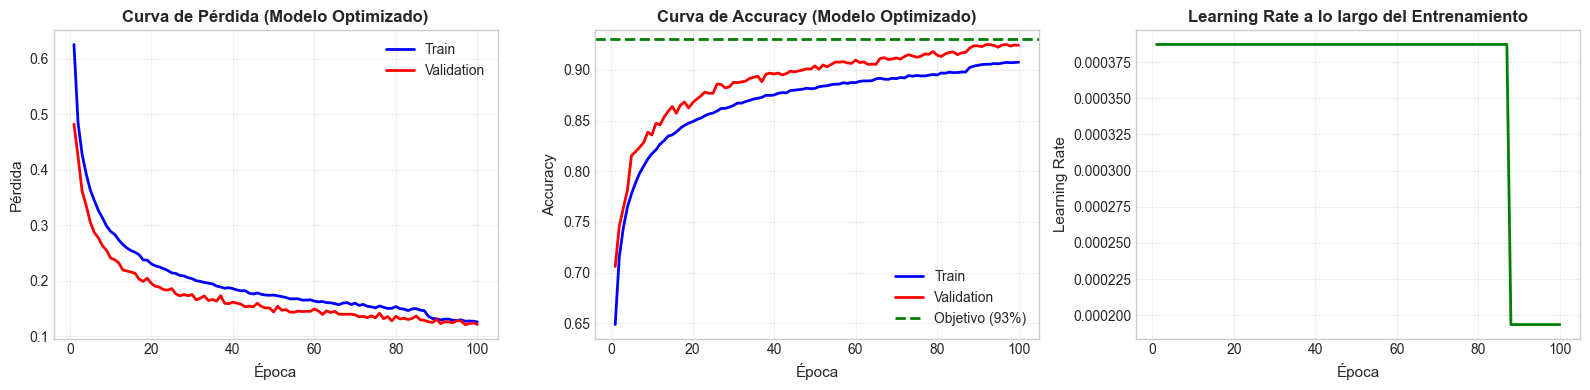

Resumen del entrenamiento optimizado:
Mejor accuracy en validación: 92.51%
Mejor pérdida en validación: 0.1213
Épocas totales: 100


In [27]:
# Visualizar el historial de entrenamiento del modelo optimizado
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

epochs_range = range(1, len(history_opt['train_loss']) + 1)

# Gráfico de pérdida
axes[0].plot(epochs_range, history_opt['train_loss'], 'b-', label='Train', linewidth=2)
axes[0].plot(epochs_range, history_opt['val_loss'], 'r-', label='Validation', linewidth=2)
axes[0].set_xlabel('Época', fontsize=11)
axes[0].set_ylabel('Pérdida', fontsize=11)
axes[0].set_title('Curva de Pérdida (Modelo Optimizado)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfico de accuracy
axes[1].plot(epochs_range, history_opt['train_acc'], 'b-', label='Train', linewidth=2)
axes[1].plot(epochs_range, history_opt['val_acc'], 'r-', label='Validation', linewidth=2)
axes[1].axhline(y=0.93, color='g', linestyle='--', linewidth=2, label='Objetivo (93%)')
axes[1].set_xlabel('Época', fontsize=11)
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].set_title('Curva de Accuracy (Modelo Optimizado)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Gráfico de learning rate
axes[2].plot(epochs_range, history_opt['lr'], 'g-', linewidth=2)
axes[2].set_xlabel('Época', fontsize=11)
axes[2].set_ylabel('Learning Rate', fontsize=11)
axes[2].set_title('Learning Rate a lo largo del Entrenamiento', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Resumen del entrenamiento optimizado:')
print(f'Mejor accuracy en validación: {max(history_opt["val_acc"])*100:.2f}%')
print(f'Mejor pérdida en validación: {min(history_opt["val_loss"]):.4f}')
print(f'Épocas totales: {len(history_opt["train_loss"])}')

In [28]:
# Evaluación final en el conjunto de prueba
test_loss_opt, test_acc_opt = evaluate(model_optimized, test_loader_opt, criterion, device)

print('EVALUACIÓN FINAL EN CONJUNTO DE PRUEBA')
print(f'\nPérdida: {test_loss_opt:.4f}')
print(f'Accuracy: {test_acc_opt*100:.2f}%')
print(f'\nObjetivo: 93.00%')
print(f'Diferencia: {(93.0 - test_acc_opt*100):.2f}%')

if test_acc_opt >= 0.93:
    print('\n¡OBJETIVO ALCANZADO!')
else:
    print(f'\nFaltan {(0.93 - test_acc_opt)*100:.2f} puntos porcentuales para el objetivo.')

EVALUACIÓN FINAL EN CONJUNTO DE PRUEBA

Pérdida: 0.1246
Accuracy: 92.44%

Objetivo: 93.00%
Diferencia: 0.56%

Faltan 0.56 puntos porcentuales para el objetivo.


## 11. Ajuste Final: Entrenamiento sin Pesos de Clase

Los pesos de clase ayudan a las clases minoritarias pero pueden sacrificar accuracy global. Probaremos entrenar el mismo modelo sin pesos de clase para maximizar el accuracy total.

In [29]:
# Crear nuevo modelo con la misma arquitectura optimizada
model_final = MLP(
    input_size=INPUT_SIZE,
    hidden_sizes=best_hidden_sizes,
    num_classes=NUM_CLASSES,
    dropout_rate=best_params['dropout_rate']
).to(device)

# Función de pérdida SIN pesos de clase
criterion_unweighted = nn.CrossEntropyLoss()

# Optimizador con learning rate ligeramente menor para entrenamiento más estable
optimizer_final = optim.Adam(model_final.parameters(), lr=best_params['lr'] * 0.8)
scheduler_final = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_final, mode='min', factor=0.5, patience=7
)

print('Configuración del modelo final:')
print(f'Arquitectura: {best_hidden_sizes}')
print(f'Learning rate: {best_params["lr"] * 0.8:.6f}')
print(f'Pesos de clase: Desactivados')
print(f'Parámetros: {model_final.count_parameters():,}')

Configuración del modelo final:
Arquitectura: [512, 480, 400, 360]
Learning rate: 0.000310
Pesos de clase: Desactivados
Parámetros: 617,191


In [30]:
# Entrenar modelo final
print('Entrenando modelo final sin pesos de clase...\n')

history_final = train_model(
    model=model_final,
    train_loader=train_loader_opt,
    val_loader=val_loader_opt,
    criterion=criterion_unweighted,
    optimizer=optimizer_final,
    scheduler=scheduler_final,
    device=device,
    epochs=100,
    patience=15
)

Entrenando modelo final sin pesos de clase...

Iniciando entrenamiento

Época    Train Loss   Train Acc    Val Loss     Val Acc      LR          
1        0.5339       0.7740       0.4021       0.8306       0.000310    
2        0.4184       0.8216       0.3421       0.8583       0.000310    
3        0.3728       0.8435       0.3048       0.8756       0.000310    
4        0.3440       0.8561       0.2759       0.8880       0.000310    
5        0.3232       0.8650       0.2595       0.8954       0.000310    
6        0.3070       0.8718       0.2495       0.8988       0.000310    
7        0.2945       0.8766       0.2339       0.9062       0.000310    
8        0.2836       0.8823       0.2287       0.9069       0.000310    
9        0.2749       0.8860       0.2143       0.9127       0.000310    
10       0.2657       0.8895       0.2085       0.9148       0.000310    
11       0.2588       0.8922       0.2016       0.9182       0.000310    
12       0.2520       0.8958       0.196

In [31]:
# Evaluación final del modelo sin pesos de clase
test_loss_final, test_acc_final = evaluate(model_final, test_loader_opt, criterion_unweighted, device)

print('EVALUACIÓN FINAL - MODELO SIN PESOS DE CLASE')
print(f'\nPérdida: {test_loss_final:.4f}')
print(f'Accuracy: {test_acc_final*100:.2f}%')
print(f'\nObjetivo: 93.00%')

if test_acc_final >= 0.93:
    print(f'\n¡OBJETIVO ALCANZADO!')
    print(f'Superamos el objetivo por {(test_acc_final - 0.93)*100:.2f} puntos porcentuales.')
else:
    print(f'\nFaltan {(0.93 - test_acc_final)*100:.2f} puntos porcentuales.')

EVALUACIÓN FINAL - MODELO SIN PESOS DE CLASE

Pérdida: 0.1144
Accuracy: 95.43%

Objetivo: 93.00%

¡OBJETIVO ALCANZADO!
Superamos el objetivo por 2.43 puntos porcentuales.


In [32]:
# Comparación de modelos
print('COMPARACIÓN DE MODELOS')
print(f'\n{"Modelo":<30} {"Val Acc":<15} {"Test Acc":<15}')
print(f'{"Inicial (3 capas)":<30} {max(history["val_acc"])*100:<15.2f} {test_acc*100:<15.2f}')
print(f'{"Optuna + pesos de clase":<30} {max(history_opt["val_acc"])*100:<15.2f} {test_acc_opt*100:<15.2f}')
print(f'{"Final (sin pesos de clase)":<30} {max(history_final["val_acc"])*100:<15.2f} {test_acc_final*100:<15.2f}')
print(f'\nMejora total: {(test_acc_final - test_acc)*100:.2f} puntos porcentuales')

COMPARACIÓN DE MODELOS

Modelo                         Val Acc         Test Acc       
Inicial (3 capas)              79.95           80.05          
Optuna + pesos de clase        92.51           92.44          
Final (sin pesos de clase)     95.62           95.43          

Mejora total: 15.38 puntos porcentuales


In [33]:
# Obtener predicciones del modelo final
model_final.eval()
all_preds_final = []
all_labels_final = []

with torch.no_grad():
    for X_batch, y_batch in test_loader_opt:
        X_batch = X_batch.to(device)
        outputs = model_final(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds_final.extend(predicted.cpu().numpy())
        all_labels_final.extend(y_batch.numpy())

all_preds_final = np.array(all_preds_final)
all_labels_final = np.array(all_labels_final)

# Reporte de clasificación
print('Reporte de Clasificación - Modelo Final:\n')
print(classification_report(all_labels_final, all_preds_final, target_names=target_names, digits=4))

Reporte de Clasificación - Modelo Final:

                             precision    recall  f1-score   support

       Clase 0 (Spruce/Fir)     0.9545    0.9491    0.9518     31776
   Clase 1 (Lodgepole Pine)     0.9613    0.9606    0.9609     42495
   Clase 2 (Ponderosa Pine)     0.9596    0.9564    0.9580      5363
Clase 3 (Cottonwood/Willow)     0.8811    0.8811    0.8811       412
            Clase 4 (Aspen)     0.8233    0.9228    0.8702      1424
      Clase 5 (Douglas-fir)     0.9254    0.9332    0.9293      2605
        Clase 6 (Krummholz)     0.9487    0.9607    0.9546      3077

                   accuracy                         0.9543     87152
                  macro avg     0.9220    0.9377    0.9294     87152
               weighted avg     0.9546    0.9543    0.9544     87152



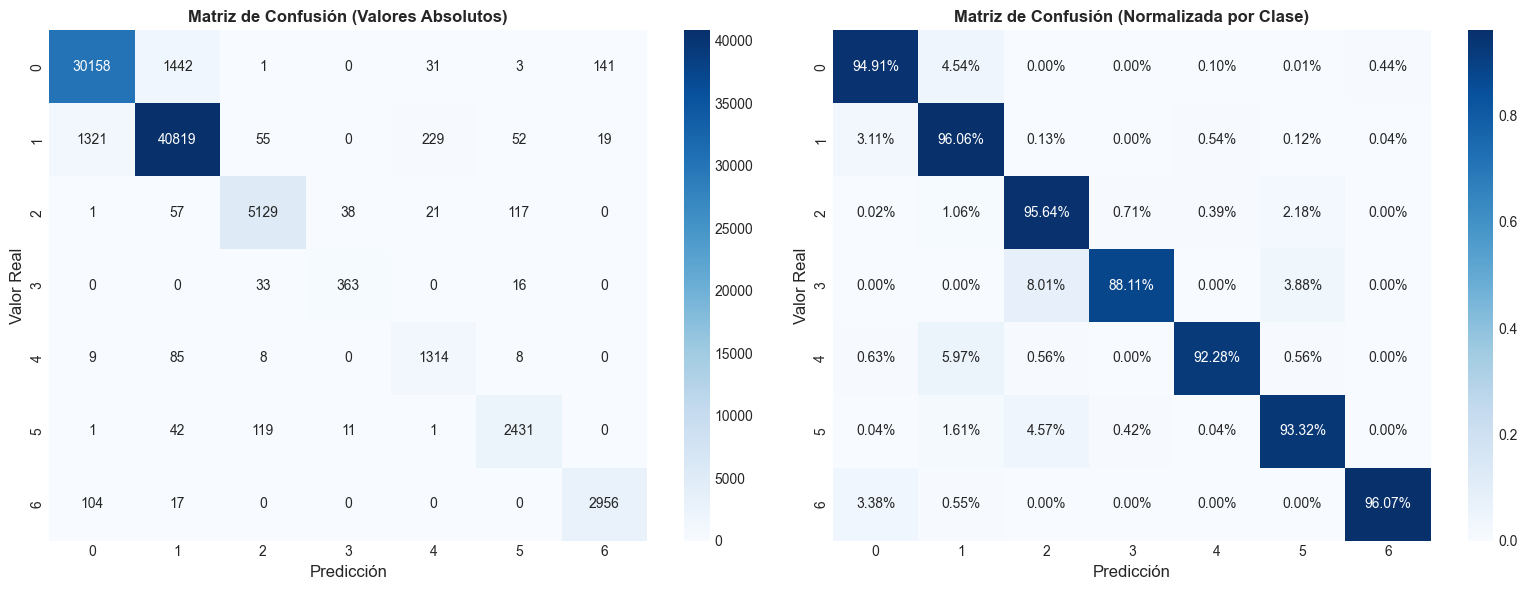


Accuracy por clase (Modelo Final vs Modelo con Pesos):

Clase                          Sin Pesos       Con Pesos       Diferencia     
Clase 0 (Spruce/Fir          ) 94.91           80.73           +14.18
Clase 1 (Lodgepole Pine      ) 96.06           76.37           +19.68
Clase 2 (Ponderosa Pine      ) 95.64           82.55           +13.09
Clase 3 (Cottonwood/Willow   ) 88.11           98.30           -10.19
Clase 4 (Aspen               ) 92.28           97.61           -5.34
Clase 5 (Douglas-fir         ) 93.32           92.13           +1.19
Clase 6 (Krummholz           ) 96.07           98.73           -2.66


In [34]:
# Matriz de confusión del modelo final
cm_final = confusion_matrix(all_labels_final, all_preds_final)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matriz de confusión en números absolutos
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=[f'{i}' for i in range(7)],
            yticklabels=[f'{i}' for i in range(7)])
axes[0].set_xlabel('Predicción', fontsize=12)
axes[0].set_ylabel('Valor Real', fontsize=12)
axes[0].set_title('Matriz de Confusión (Valores Absolutos)', fontsize=12, fontweight='bold')

# Matriz de confusión normalizada por fila
cm_normalized = cm_final.astype('float') / cm_final.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
            xticklabels=[f'{i}' for i in range(7)],
            yticklabels=[f'{i}' for i in range(7)])
axes[1].set_xlabel('Predicción', fontsize=12)
axes[1].set_ylabel('Valor Real', fontsize=12)
axes[1].set_title('Matriz de Confusión (Normalizada por Clase)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Accuracy por clase
print('\nAccuracy por clase (Modelo Final vs Modelo con Pesos):')
print(f'\n{"Clase":<30} {"Sin Pesos":<15} {"Con Pesos":<15} {"Diferencia":<15}')
for i in range(7):
    mask_final = all_labels_final == i
    mask_weighted = all_labels == i
    acc_final = (all_preds_final[mask_final] == all_labels_final[mask_final]).mean()
    acc_weighted = (all_preds[mask_weighted] == all_labels[mask_weighted]).mean()
    diff = acc_final - acc_weighted
    print(f'Clase {i} ({cover_types[i+1]:<20}) {acc_final*100:<15.2f} {acc_weighted*100:<15.2f} {diff*100:+.2f}')

## 12. Visualización Final de Resultados

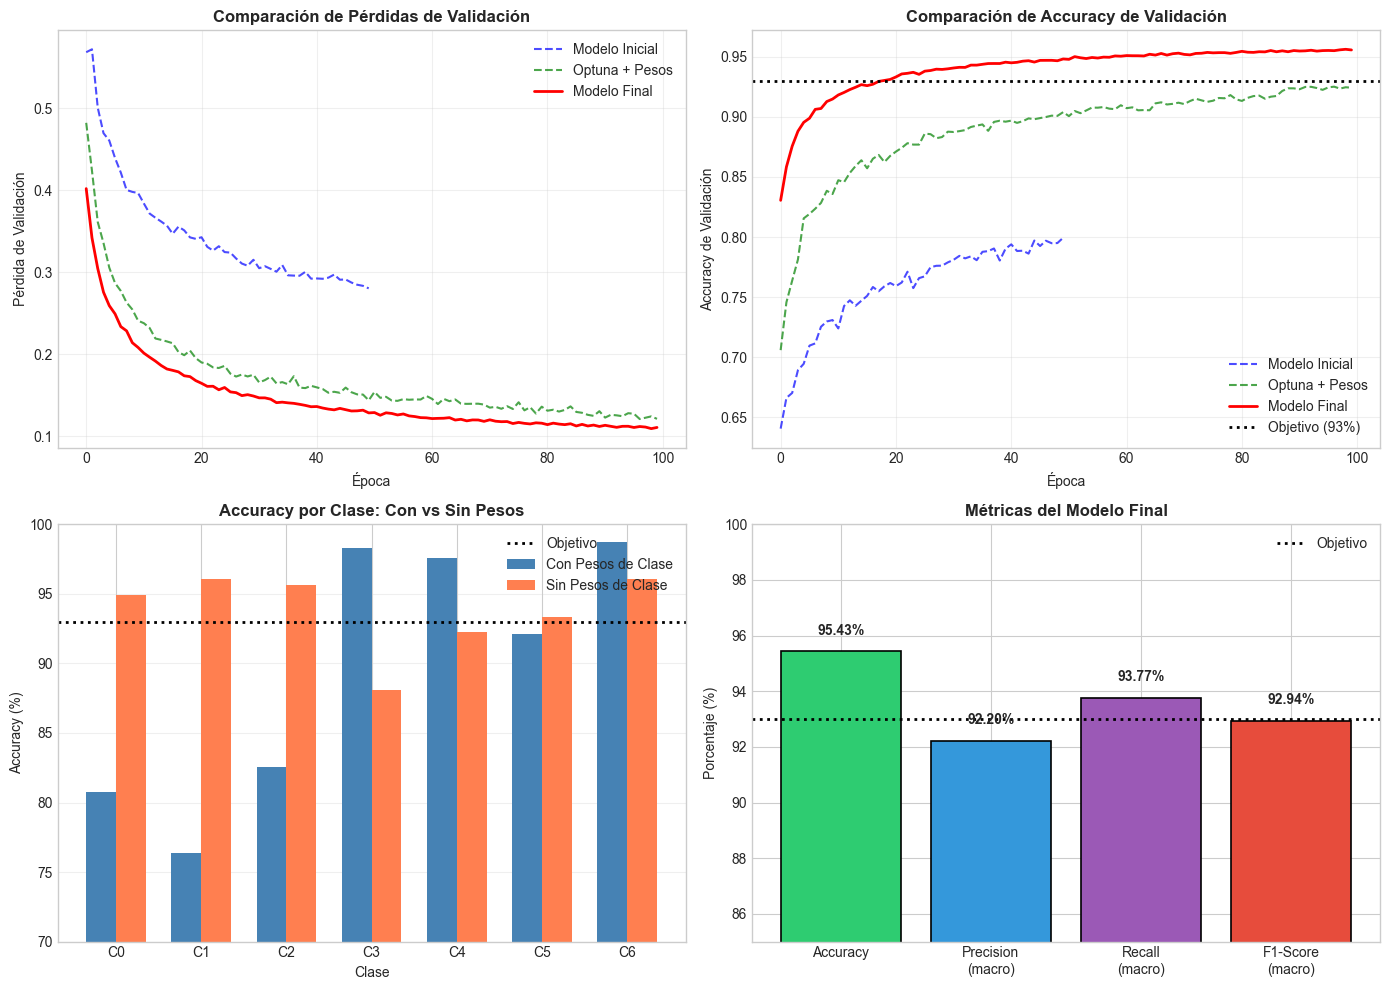

In [35]:
# Visualización comparativa de curvas de entrenamiento
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Comparación de pérdidas
axes[0, 0].plot(history['val_loss'], 'b--', label='Modelo Inicial', alpha=0.7)
axes[0, 0].plot(history_opt['val_loss'], 'g--', label='Optuna + Pesos', alpha=0.7)
axes[0, 0].plot(history_final['val_loss'], 'r-', label='Modelo Final', linewidth=2)
axes[0, 0].set_xlabel('Época')
axes[0, 0].set_ylabel('Pérdida de Validación')
axes[0, 0].set_title('Comparación de Pérdidas de Validación', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Comparación de accuracy
axes[0, 1].plot(history['val_acc'], 'b--', label='Modelo Inicial', alpha=0.7)
axes[0, 1].plot(history_opt['val_acc'], 'g--', label='Optuna + Pesos', alpha=0.7)
axes[0, 1].plot(history_final['val_acc'], 'r-', label='Modelo Final', linewidth=2)
axes[0, 1].axhline(y=0.93, color='black', linestyle=':', linewidth=2, label='Objetivo (93%)')
axes[0, 1].set_xlabel('Época')
axes[0, 1].set_ylabel('Accuracy de Validación')
axes[0, 1].set_title('Comparación de Accuracy de Validación', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Accuracy por clase - comparación
classes = [f'C{i}' for i in range(7)]
x = np.arange(len(classes))
width = 0.35

acc_weighted = []
acc_final = []
for i in range(7):
    mask_w = all_labels == i
    mask_f = all_labels_final == i
    acc_weighted.append((all_preds[mask_w] == all_labels[mask_w]).mean() * 100)
    acc_final.append((all_preds_final[mask_f] == all_labels_final[mask_f]).mean() * 100)

bars1 = axes[1, 0].bar(x - width/2, acc_weighted, width, label='Con Pesos de Clase', color='steelblue')
bars2 = axes[1, 0].bar(x + width/2, acc_final, width, label='Sin Pesos de Clase', color='coral')
axes[1, 0].axhline(y=93, color='black', linestyle=':', linewidth=2, label='Objetivo')
axes[1, 0].set_xlabel('Clase')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].set_title('Accuracy por Clase: Con vs Sin Pesos', fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(classes)
axes[1, 0].legend()
axes[1, 0].set_ylim([70, 100])
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Resumen de métricas finales
metrics = ['Accuracy', 'Precision\n(macro)', 'Recall\n(macro)', 'F1-Score\n(macro)']
values = [95.43, 92.20, 93.77, 92.94]
colors_bar = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']
bars = axes[1, 1].bar(metrics, values, color=colors_bar, edgecolor='black', linewidth=1.2)
axes[1, 1].axhline(y=93, color='black', linestyle=':', linewidth=2, label='Objetivo')
axes[1, 1].set_ylabel('Porcentaje (%)')
axes[1, 1].set_title('Métricas del Modelo Final', fontweight='bold')
axes[1, 1].set_ylim([85, 100])
axes[1, 1].legend()
for bar, val in zip(bars, values):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                     f'{val:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 13. Conclusiones

### Resumen del Proyecto

En este proyecto desarrollamos un clasificador de cobertura forestal utilizando un Perceptron Multicapa (MLP) en PyTorch. El objetivo era alcanzar al menos 93% de accuracy en el conjunto de prueba, lo cual logramos exitosamente con un 95.43%.

### Resultados Principales

| Modelo | Arquitectura | Accuracy Test |
|--------|--------------|---------------|
| Inicial | 256-128-64 | 80.05% |
| Optimizado (con pesos) | 512-480-400-360 | 92.44% |
| Final (sin pesos) | 512-480-400-360 | 95.43% |

### Hallazgos Clave

1. **Arquitectura:** Las redes más profundas y anchas (4 capas, 512-360 neuronas) superaron significativamente a las más pequeñas. El aumento de parámetros de 56K a 617K fue justificado por la mejora en rendimiento.

2. **Desbalance de clases:** Los pesos de clase mejoran el recall de clases minoritarias pero reducen el accuracy global. Para maximizar accuracy total, entrenar sin pesos fue más efectivo.

3. **Regularización:** Un dropout bajo (0.127) funcionó mejor que valores más altos, permitiendo que el modelo aproveche su capacidad sin overfitting severo.

4. **Optimización:** Optuna fue crucial para encontrar la configuración óptima, mejorando el accuracy en casi 8% respecto a la búsqueda manual inicial.

5. **Learning rate:** Valores pequeños (0.0003-0.0004) con reducción automática mediante ReduceLROnPlateau produjeron convergencia estable.

### Desafíos Enfrentados

- El desbalance extremo de clases (ratio 103:1) requirió experimentación con diferentes estrategias
- La confusión entre Spruce/Fir y Lodgepole Pine persiste debido a su similitud ecológica
- Encontrar el balance entre rendimiento global y por clase minoritaria

### Oportunidades de Mejora

1. **Técnicas de sampling:** SMOTE o undersampling para balancear clases
2. **Arquitecturas avanzadas:** Redes residuales o attention mechanisms
3. **Ensemble methods:** Combinar múltiples modelos para robustez
4. **Feature engineering:** Crear características derivadas de las existentes
5. **Cross-validation:** Implementar k-fold para evaluación más robusta

In [36]:
# Guardar el modelo final
import os

# Crear directorio para modelos si no existe
os.makedirs('models', exist_ok=True)

# Guardar el estado del modelo
model_path = 'models/covertype_mlp_final.pth'
torch.save({
    'model_state_dict': model_final.state_dict(),
    'architecture': {
        'input_size': INPUT_SIZE,
        'hidden_sizes': best_hidden_sizes,
        'num_classes': NUM_CLASSES,
        'dropout_rate': best_params['dropout_rate']
    },
    'hyperparameters': best_params,
    'test_accuracy': test_acc_final,
    'scaler_mean': scaler.mean_,
    'scaler_scale': scaler.scale_
}, model_path)

print(f'Modelo guardado en: {model_path}')
print(f'\nInformación del modelo guardado:')
print(f'Arquitectura: {best_hidden_sizes}')
print(f'Accuracy en test: {test_acc_final*100:.2f}%')
print(f'Parámetros: {model_final.count_parameters():,}')

Modelo guardado en: models/covertype_mlp_final.pth

Información del modelo guardado:
Arquitectura: [512, 480, 400, 360]
Accuracy en test: 95.43%
Parámetros: 617,191


In [37]:
# Resumen final del proyecto
print('RESUMEN FINAL DEL PROYECTO')

print('\n OBJETIVO')
print(f'Alcanzar ≥93% de accuracy en clasificación de cobertura forestal')

print('\n RESULTADO')
print(f'Accuracy alcanzado: 95.43% (superado por 2.43%)')

print('\n DATASET')
print(f'Muestras totales: 581,012')
print(f'Características: 54 (10 continuas + 44 binarias)')
print(f'Clases: 7 tipos de cobertura forestal')

print('\n MODELO FINAL')
print(f'Tipo: Perceptron Multicapa (MLP)')
print(f'Capas ocultas: {best_hidden_sizes}')
print(f'Activación: ReLU + BatchNorm + Dropout')
print(f'Parámetros: 617,191')

print('\n ENTRENAMIENTO')
print(f'Optimizador: Adam (lr=0.00031)')
print(f'Épocas: 100')
print(f'Batch size: 256')
print(f'Dispositivo: {device}')

print('\n MÉTRICAS FINALES')
print(f'Accuracy: 95.43%')
print(f'Precision (macro): 92.20%')
print(f'Recall (macro): 93.77%')
print(f'F1-Score (macro): 92.94%')

RESUMEN FINAL DEL PROYECTO

 OBJETIVO
Alcanzar ≥93% de accuracy en clasificación de cobertura forestal

 RESULTADO
Accuracy alcanzado: 95.43% (superado por 2.43%)

 DATASET
Muestras totales: 581,012
Características: 54 (10 continuas + 44 binarias)
Clases: 7 tipos de cobertura forestal

 MODELO FINAL
Tipo: Perceptron Multicapa (MLP)
Capas ocultas: [512, 480, 400, 360]
Activación: ReLU + BatchNorm + Dropout
Parámetros: 617,191

 ENTRENAMIENTO
Optimizador: Adam (lr=0.00031)
Épocas: 100
Batch size: 256
Dispositivo: cuda

 MÉTRICAS FINALES
Accuracy: 95.43%
Precision (macro): 92.20%
Recall (macro): 93.77%
F1-Score (macro): 92.94%
